In [1]:
import random
import itertools
import math

import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from Ball_Tree import Ball_Tree

In [2]:
np.random.seed(42)

In [3]:
#This is a really easy case
X, y= sklearn.datasets.make_blobs(n_samples=1000, cluster_std=.3, centers=[(2,2),(4,2)])
scaled_X = MinMaxScaler().fit_transform(X)

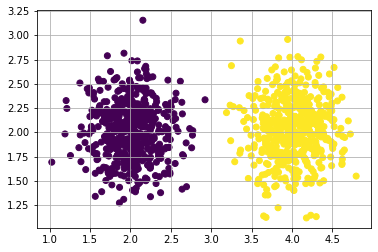

In [4]:
plt.grid()
plt.scatter(X[:,0],X[:,1],c=y)

In [5]:
class Clusterer():
    
    def __init__(self, gridsize=10, n_elements=1, eps=.1):
        self.gridsize = gridsize
        self.eps = eps
        self.n_elements = n_elements
        
    def fit(self, X):
        tree = Ball_Tree(X, self.n_elements)
        self.grid = self._initialize_grid(X, tree) # self is temp for debug
        
    def _initialize_grid(self, X, tree):
        n_dim = X.shape[1]
        min_coord = X.min() - self.eps*1.0001 #the 1.001 is a fudge factor. Want points at edge to have 0 density
        max_coord = X.max() + self.eps*1.0001
        width = max_coord - min_coord
        offset = width / (self.gridsize)
        # realy (gridsize - 1 + 1) -1 because we want offset*(gridsize-1)+ min_pts to evaluate to max
        #+1 because we actually want gridsize to add padding so we can compute gradient at ends 
       
        density_shape = (self.gridsize+1,)*n_dim
        density_grid = np.empty(density_shape)
        density_grid_indices = itertools.product(range(self.gridsize+1),repeat=n_dim)
        for grid_i in density_grid_indices:
            coords = np.array([offset*i+min_coord for i in grid_i])
            #coords is a coordinate pair in n_dim space
            density_grid[grid_i] = tree.calc_local_density(coords, self.eps)

        #desnity grid now contains densities of each point in the grid
        gradient_shape = (self.gridsize,)*n_dim+(n_dim+1,) 
        #last dimension is dimensionality of the gradient itself plus one for magnitude

        gradient_grid = np.empty(gradient_shape)
        gradient_grid_indices = itertools.product(range(self.gridsize),repeat=n_dim)
        for grid_i in gradient_grid_indices:
            this_density = density_grid[grid_i]
            this_gradient = [this_density - density_grid[grid_i[:dim]+((grid_i[dim]+1),)+grid_i[dim+1:]] for dim in range(n_dim)]
            #note gradient goes towards lower density
            magnitude = np.linalg.norm(this_gradient)
            if magnitude > 0:
                this_gradient = [partial/magnitude for partial in this_gradient]
            this_gradient.append(magnitude)
            gradient_grid[grid_i] = this_gradient
            
            #for debugging only
            self.density_grid = density_grid
        return gradient_grid

In [12]:
def plot_2d_gradient_grid(grid, X, y, eps):
    n_dim = 2
    max_vector_len = grid[:,...,-1].max()
    print(grid[3,3,:])
    print(max_vector_len)
    gradient_grid_indices = itertools.product(range(grid.shape[0]),repeat=n_dim)
    np.arrange(grid.shape[0])
    plt.quiver(gradient_grid[0])
    #use plt.quiver to plot the vectors. use create an x,y using the code for x,y in density values.
    #probably need to mul by magnitude for good results

def plot_2d_density_values(grid, X, y, eps):
    n_dim = 2
    min_coord = X.min() - eps*1.0001 #the 1.001 is a fudge factor. Want points at edge to have 0 density
    max_coord = X.max() + eps*1.0001
    width = max_coord - min_coord
    offset = width / (grid.shape[0] - 1) # this is necessary because you want to have points on both ends
    max_density = grid.max()
    plt.scatter(scaled_X[:,0],scaled_X[:,1],c=y, marker='.')
    for grid_i in itertools.product(range(grid.shape[0]),repeat=n_dim):
        coords = np.array([offset*i+min_coord for i in grid_i])
        #coords is a coordinate pair in n_dim space
        plt.scatter(coords[0], coords[1], c='y', alpha=.5,  marker='+')
        plt.scatter(coords[0], coords[1], alpha=((grid[grid_i]/max_density)**.3), c='k')
        

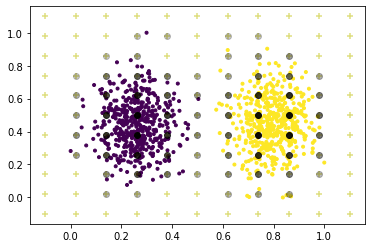

[ 0.58340032 -0.81218475 87.4185335 ]
118.00423721205946


In [13]:
clusterer = Clusterer(eps=.1)
clusterer.fit(scaled_X)
plot_2d_density_values(clusterer.density_grid, scaled_X, y, .1)
plt.show()
plot_2d_gradient_grid(clusterer.grid, scaled_X, y, .1)

In [ ]:
grid = np.array([[x[0]*(1/9)-.03,x[1]*(1/9)-.03] for x in itertools.product(range(10),repeat=2)])
plt.show()

## Debugging Ball Tree

In [38]:
def naive_density(data_pt, X, epsilon):
    return np.nonzero((distance.cdist(data_pt.reshape(1,-1), X) < epsilon)[0])[0].shape[0]

In [7]:
def compare(data_pt, epsilon):
    print(f'naive:{naive_density(data_pt, X, epsilon)}\tball:{tree.calc_local_density(data_pt, epsilon)}')
def compare_bool(data_pt, epsilon):
    n_d = naive_density(data_pt, X, epsilon)
    b_d = tree.calc_local_density(data_pt,epsilon)
    if n_d != b_d:
        print(f'{n_d}!={b_d}')
        print(type(n_d), type(b_d))

In [8]:
a=np.array([0,1])
b = np.array([0,0])
for x in X:
    compare_bool(x, random.random() * 2)


In [ ]:
tree.root.data_pt

In [ ]:
tree.root.radius

In [ ]:
distance.euclidean(a,tree.root.data_pt) + tree.root.radius

In [ ]:
def plot_node(node, color):
    plt.scatter(X[:,0],X[:,1],c=y)
    plt.scatter(node.data_pt[0], node.data_pt[1], c=color)
    plt.axis("equal")
    plt.grid()
    plt.show()

In [ ]:

left = tree.root
right = tree.root
while left:
    print(left.data_pt, X[left.data_pt_i], left.n_elements, left.radius)
    plot_node(left, 'r')
    plot_node(right, 'b')
    left = left.left
    right = right.right

## scratch

In [ ]:
arr = np.array([[1,2,3],[4,5,6]])

In [ ]:
(arr[0] <=2).sum()

In [ ]:
type((distance.cdist(np.array([0,0,0]).reshape(1,-1), arr)[0] <= 2).sum())